# Анализ тональности текста для нового сервиса Викишоп

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Цель - построить модель, которая будет классифицировать комментарии на позитивные и негативные.**

Для исследования получены распоряжении набор данных с разметкой о токсичности правок.

Заранее оговорено значение метрики качества F1 **не меньше 0.75**. 

Данные находятся в файле `toxic_comments.csv`. Столбец text в нём содержит текст комментария, а toxic — целевой признак.

Исследование пройдет в несколько этапов:
1. Обзор данных.
2. Подготовка данных.
3. Обучение разных моделей.
5. Выводы.


## 1. Обзор данных

In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import spacy

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay


import nltk
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from gensim.models import Word2Vec


RANDOM_STATE = 42
sns.set_palette("pastel")
pd.set_option('display.max_colwidth', None)

In [2]:
if os.path.exists('toxic_comments.csv'):
    comments = pd.read_csv('toxic_comments.csv')
elif os.path.exists('/datasets/toxic_comments.csv'):
    comments = pd.read_csv('/datasets/toxic_comments.csv')
else:
    print('Something is wrong')


In [3]:
comments.sample(3)

,Unnamed: 0,text,toxic
117632,117731,"""\nplease continue the discussion at []. talk """,0
82379,82457,"""\n Yes, a lot of your points I addressed at HP, so aha! Thank you! — (T/C) """,0
118977,119077,I just wanted to make it clear. It might have not been necessary (which why I didn't fight to keep it) but it wasn't vandalism. He only posted me on WP:AIV because he doesn't like me. Btw i reposted the warnings on my page to show I mean no vandalism. 74.89.58.36,0


In [4]:
comments = comments.drop(columns=['Unnamed: 0'])

In [5]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [6]:
print(comments.duplicated().sum())
print(comments.text.duplicated().sum())

0
0


In [7]:
comments.toxic.value_counts()

toxic
0    143106
1     16186
Name: count, dtype: int64

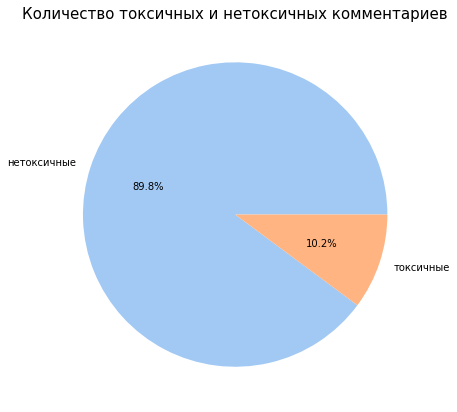

In [8]:
plt.figure(figsize=(7,7))
plt.pie(comments.toxic.value_counts(), labels =['нетоксичные', 'токсичные'], autopct='%1.1f%%' )
plt.title('Количество токсичных и нетоксичных комментариев', fontsize=15);

In [9]:
comments.text.sample(5)

22679                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Haha, again, loving it ')
65920     Notable players of sol islands...you know\nFirstly, Mal Meninga is of South Sea Island Descent, his father was a South Sea Islander and some islands in the Polynesian Triangle, as it is known, are included in the Solomon Islands.\n\nAs for the rest of the play

## Вывод
- В таблице содержатся текст комментария и его разметка (токсичный - 1 или нет - 0), что соответствует описанию задачи.
- Всего в таблице 159292 записи. Пропусков и дубликатов записей нет.
- Доля токсичных комментариев составляет 10% от всех.
- Комментарии представлены на английском языке.


## 2. Подготовка данных

Сначала уберем все символы кроме букв, текст в нижний регистр.

Нужно произвести токенизацию и лемматизацию текстов перед тем как векторизовать их. 


У нас английский текст. Произведем преобразования текстов с помощью библиотеки spacy. 

Следить за прогрессом будем с помощью инструментов библиотеки tqdm.

In [10]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

corpus = comments['text']
processed_corpus = []
corpus = corpus.apply(lambda x: ' '.join(re.sub(r'[^a-zA-Z]', ' ', x).lower().split()))

for doc in tqdm(nlp.pipe(corpus), total=len(corpus), desc="Processing"):
    processed_corpus.append([token.lemma_ for token in doc])


lemmatized_corpus = [' '.join(lemmas) for lemmas in processed_corpus]

Processing:   1%|▏         | 2049/159292 [00:23<53:16, 49.20it/s]  Processing: 100%|██████████| 159292/159292 [24:25<00:00, 108.67it/s]


In [11]:
lemmatized_corpus = np.array(lemmatized_corpus)

In [12]:
lemmatized_corpus[0]

'explanation why the edit make under my username hardcore metallica fan be revert they weren t vandalism just closure on some gas after I vote at new york dolls fac and please don t remove the template from the talk page since I m retire now'

### Вывод:
- Тексты комментариев были последовательно обработаны:
    - удалено все кроме слов
    - все слова переведены в нижний регистр
    - проведена токенизация
    - проведена лемматизация
    - отдельные слова снова соединили в единую строку

## 3. Обучение 

### 3.1. Мешок слов и TD-IDF
Теперь у нас есть лемматизированные тексты. Перейдем к преобразованию в векторы. 

Попробуем модель **мешок слов**.

В качестве классификатора будем использовать **логистическую регрессию**.

Сразу разделим выборку на трейн и тест:

In [13]:
X_train,X_test, y_train, y_test = train_test_split(lemmatized_corpus, comments.toxic, test_size=0.1, random_state=RANDOM_STATE, stratify=comments.toxic)

for el in [X_train,X_test, y_train, y_test]:
    print(el.shape)

(143362,)
(15930,)
(143362,)
(15930,)


Обучим мешок слов с логистической регрессией и посмотрим качество на кроссвалидации.

In [14]:
nltk.download('stopwords')

stop_words = stopwords.words('english')

pipeline = Pipeline(
    [
        ("vect", CountVectorizer(stop_words = stop_words)),
        ("clf", LogisticRegression(random_state=RANDOM_STATE, max_iter = 200)),
    ]
)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\very-\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
strat_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

In [16]:
cv = cross_val_score(pipeline, X_train, y_train, scoring="f1", cv=strat_kfold).mean()
cv


0.7600512315132549

Получаем неплохое значение метрики F1, которое подходит под заданный критерий качества.

Теперь попробуем использовать векторайзер TF-IDF.

In [17]:
pipeline_tfidf = Pipeline(
    [
        ("vect", TfidfVectorizer(stop_words = stop_words)),
        ("clf", LogisticRegression(random_state=RANDOM_STATE, max_iter = 200)),
    ]
)

In [18]:
cv = cross_val_score(pipeline_tfidf, X_train, y_train, scoring="f1", cv=strat_kfold).mean()
cv

0.7315502139159641

Использование в качестве векторайзера TF-IDF дает результат немного хуже.

Будем использовать мешок слов и подберем для этого варианта коэффициент регуляризации логистической регрессии.

In [19]:
param_distributions = [
    
        {'clf__C': range(5, 15,2),}

]

In [20]:
search_cv = GridSearchCV(pipeline, 
                param_grid= param_distributions,
                scoring='f1',
                cv=strat_kfold)

search_cv.fit(X_train,y_train)

c:\Users\very-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\very-\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'its',
                                                                    'itself', ...])),
                                       ('clf',
                                        LogisticRegression(max_iter=200,
                                                           random_state=42))]),
             param_grid=[{'clf__C': range(5, 15, 2)}], scoring='f1')

In [21]:
print(search_cv.best_score_)
print(search_cv.best_estimator_)

0.7666236220054227
Pipeline(steps=[('vect',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('clf',
                 LogisticRegression(C=5, max_iter=200, random_state=42))])


За счет увеличения коэффициента С (ослабления регуляризации) удалось добиться увеличения метрики качества.



### 3.2 Word2vec

Попробуем еще один вариант векторизации текста - Word2vec. 

Сначала обучим на части трейне, а потом векторизуем все данные.

In [22]:
X_train_wv, X_valid_wv, y_train_wv,y_valid_wv = train_test_split(X_train, y_train, test_size=0.1, random_state=RANDOM_STATE , stratify=y_train)

sentences = [text.split() for text in X_train_wv]

w2v = Word2Vec(sentences, vector_size=100, window=4, min_count=1, workers=4, sg=0, hs=0, negative=5, seed = RANDOM_STATE)

In [23]:
def comment_to_vec(comment, model):
    words = comment.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size) 
    return np.mean(word_vectors, axis=0)

X_train_wv = np.array([comment_to_vec(text, w2v) for text in X_train_wv])
X_valid_wv = np.array([comment_to_vec(text, w2v) for text in X_valid_wv])




Посмотрим качество только для **логистической регрессии**.

In [24]:
model = LogisticRegression(random_state=RANDOM_STATE, C=5, max_iter = 200)
model.fit(X_train_wv, y_train_wv)
preds = model.predict(X_valid_wv)
f1_score(y_valid_wv, preds)

0.6286902286902287

У F1 для w2v и логрег довольно низкое значение. Ниже критерия качества. 

### 3.3 Качество лучшей модели на тестовой выборке

Итак, лучшая модель - **мешок слов с логистической регрессией (с коэффициентом регуляризации С=5 )**.

Посмотрим для нее качество на тесте:


In [25]:
preds = search_cv.best_estimator_.predict(X_test)
f1_score(y_test, preds)

0.7787668974612595

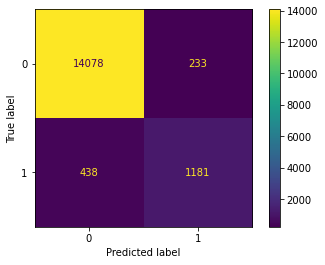

In [26]:
cm = confusion_matrix(y_test, preds)

cm_display = ConfusionMatrixDisplay(cm).plot()

Получилось, что превалирующий класс классифицируется более точно, чем второй. Но все же точность прогноза приемлима для обоих классов.

### Вывод

- Рассмотрели три вида векторизации текстов (мешок слов, TF-IDF, word2vec) вместе с логистической регрессией в качестве классификатора.
- На кросс валидации лучший результат показал вариант **мешок слов и логистическая регрессия**.
- Улучшили качество за счет подбора гиперпараметра С для логистической регрессии (С=5).
- Качество на тестовой выборке для лучшего варианта F1 = 0.78, что соответствует критерию.

## 4. Итоговый вывод

**Обзор данных**
- В таблице содержатся текст комментария и его разметка (токсичный - 1 или нет - 0), что соответствует описанию задачи.
- Всего в таблице 159292 записи. Пропусков и дубликатов записей нет.
- Доля токсичных комментариев составляет 10% от всех.
- Комментарии представлены на английском языке.

**Подготовка данных**

В представленных текстах удалили все кроме слов, все слова перевели в нижний регистр, провели токенизацию и лемматизацию.

**Обучение**
- Рассмотрели три вида векторизации текстов (мешок слов, TF-IDF, word2vec) вместе с логистической регрессией в качестве классификатора.
- На кросс валидации лучший результат показал вариант **мешок слов и логистическая регрессия**.
- Улучшили качество за счет подбора гиперпараметра С для логистической регрессии (С=5).
- Качество на тестовой выборке для лучшего варианта F1 = 0.78, что соответствует критерию.

*Таким образом, были рассмотрены разные модели и найдена лучшая модель, которая классифицирует комментарии на токсичные и нетоксичные относительно точно (F1 = 0.78) в соответствии с заданным критерием качества.*